In [26]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

In [27]:
path='E:\kuliah\Tubes_AIPlatform/mazon_cells_labelled.txt'
df=pd.read_csv(path,delimiter='\t',header=None, names=["text","sentiment"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       1000 non-null   object
 1   sentiment  1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


In [28]:
df.head()

,text,sentiment
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


In [29]:
df['sentiment'].value_counts()

0    500
1    500
Name: sentiment, dtype: int64

In [30]:
df.isna().sum()

text         0
sentiment    0
dtype: int64

In [31]:
df.duplicated().sum()

10

In [32]:
def remove_stopwords(text):
    stop_words = stopwords.words('english')
    words = text.split()
    filtered_sentence = ''
    for word in words:
        if word not in stop_words:
            filtered_sentence = filtered_sentence + word + ' '
    return filtered_sentence

In [33]:
#Handling Special Characters
def normalize_text(text):
    text = text.lower()
    # get rid of urls
    text = re.sub('https?://\S+|www\.\S+', '', text)
    # get rid of non words and extra spaces
    text = re.sub('\\W', ' ', text)
    text = re.sub('\n', '', text)
    text = re.sub(' +', ' ', text)
    text = re.sub('^ ', '', text)
    text = re.sub(' $', '', text)
    return text

In [34]:
def remove_punctuation(text):
    table = str.maketrans('','',string.punctuation)
    words = text.split()
    filtered_sentence = ''
    for word in words:
        word = word.translate(table)
        filtered_sentence = filtered_sentence + word + ' '
    return filtered_sentence

In [35]:
def stemming(text):
    ps = PorterStemmer()
    words = text.split()
    filtered_sentence = ''
    for word in words:
        word = ps.stem(word)
        filtered_sentence = filtered_sentence + word + ' '
    return filtered_sentence

In [36]:
def clean_text(text):
    text = text.lower()
    text = text.replace(',',' , ')
    text = text.replace('.',' . ')
    text = text.replace('/',' / ')
    text = text.replace('@',' @ ')
    text = text.replace('#',' # ')
    text = text.replace('?',' ? ')
    text = normalize_text(text)
    text = remove_punctuation(text)
    text = remove_stopwords(text)
    text = stemming(text)
    return text

In [37]:
from sklearn.preprocessing import OneHotEncoder
X = df["text"]
y = df['sentiment']

one = OneHotEncoder()
y = one.fit_transform(np.asarray(y).reshape(-1,1)).toarray()

In [38]:
y

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [39]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   test_size=0.3,
                                                   random_state=42,
                                                   shuffle=True)

In [40]:
vocab_size = 15000
max_length = 50
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>' 

In [41]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)

In [42]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [43]:
from keras.utils import pad_sequences
X_train = pad_sequences(X_train, maxlen=max_length,
                         padding=padding_type,
                         truncating=trunc_type)
X_test = pad_sequences(X_test, maxlen=max_length,
                         padding=padding_type,
                         truncating=trunc_type)

In [44]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout
from keras.callbacks import EarlyStopping

In [45]:
def build_model():
    model = Sequential()
    #Embedding layer converts words into dense vectors of fixed size (64 dimensions) for neural network processing. 
    #Input length is set to the max_length defined earlier.
    model.add(Embedding(vocab_size, 64, input_length=max_length))
    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(32, return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(32))
    model.add(Dropout(0.2))
    
    model.add(Dense(32, activation='relu'))
    model.add(Dense(2, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='accuracy', patience=1)  # Apply early stopping

    return model

In [46]:
model=build_model()
batch_size = 400
history = model.fit(X_train,y_train,epochs=25,batch_size=batch_size,validation_split=.2)

Epoch 1/25
2/2 [==============================] - 5s 1s/step - loss: 0.6936 - accuracy: 0.4679 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/25
2/2 [==============================] - 0s 135ms/step - loss: 0.6929 - accuracy: 0.5089 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 3/25
2/2 [==============================] - 0s 131ms/step - loss: 0.6931 - accuracy: 0.5054 - val_loss: 0.6936 - val_accuracy: 0.5000
Epoch 4/25
2/2 [==============================] - 0s 145ms/step - loss: 0.6932 - accuracy: 0.5071 - val_loss: 0.6935 - val_accuracy: 0.5000
Epoch 5/25
2/2 [==============================] - 0s 145ms/step - loss: 0.6936 - accuracy: 0.5054 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 6/25
2/2 [==============================] - 0s 145ms/step - loss: 0.6933 - accuracy: 0.5125 - val_loss: 0.6936 - val_accuracy: 0.5000
Epoch 7/25
2/2 [==============================] - 0s 133ms/step - loss: 0.6920 - accuracy: 0.5036 - val_loss: 0.6937 - val_accuracy: 0.5000
Epoch 8/25
2/2 [=======

In [47]:
score = model.evaluate(np.asarray(X_test),np.asarray(y_test))

10/10 [==============================] - 0s 11ms/step - loss: 0.5041 - accuracy: 0.8100


In [48]:
import tensorflow as tf
predicted = model.predict(X_test)
predicted = tf.squeeze(predicted)

10/10 [==============================] - 1s 10ms/step


In [49]:
import numpy as np
actual = np.argmax(y_test,axis=1)
predicted = np.argmax(predicted,axis=1)

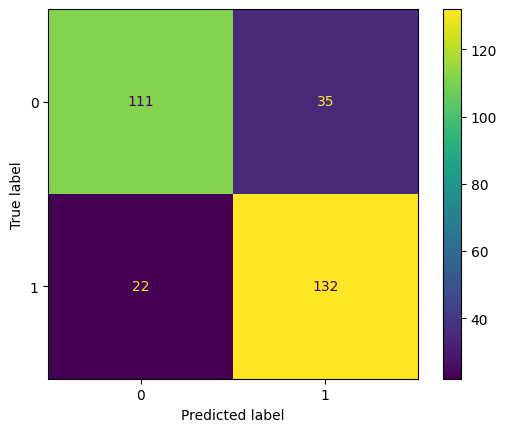

In [50]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
conf_mat = confusion_matrix(actual, predicted)

displ = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
displ.plot()